In [1]:
%%bash
if [ -d "data" ] 
then
    echo "Data already downloaded"
else
    kaggle competitions download -c knsi-golem-3
    mkdir "data"
    unzip knsi-golem-3.zip -d "data"
    rm knsi-golem-3.zip
    echo "Data downloaded"
fi

Data already downloaded


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

## Load data

In [3]:
train_df = pd.read_csv('data/train.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

## Prepare labels

In [4]:
train_y = train_df['num_sold'].to_numpy()

In [5]:
print(train_y)
print(train_y.shape)

[ 4. 13.  0. ...  0.  1.  0.]
(92092,)


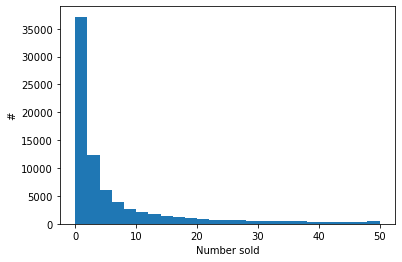

In [6]:
plt.figure()
plt.hist(train_y, bins=25, range=(0, 50))
plt.xlabel('Number sold')
plt.ylabel('#')
plt.show()

## Preprocess data

### Utilities

In [7]:
class Vectorizer:

    def __init__(self, cat_min_count=40):
        self.cat_cols = ['game_type', 'category', 'mechanic']
        self.cat_min_count = cat_min_count
        self.cat2id = {}

        self.cont_cols = [
            'year', 'min_players', 'max_players',
            'min_age', 'min_time', 'max_time']
        self.imputer = SimpleImputer(
            missing_values=np.nan, strategy='mean')

    def fit(self, df):
        df = df.copy()
        
        # Categorical
        for cat_col in self.cat_cols:
            vals = []
            for v in df[cat_col].to_numpy():
                v = str(v)
                if v == 'nan':
                    continue
                vals.extend([v_.strip() for v_ in v.split('|')])
            uniq_vals, counts = np.unique(vals, return_counts=True)
            uniq_vals = [
                v for v, c in zip(uniq_vals, counts)
                if c >= self.cat_min_count]
            self.cat2id[cat_col] = {
                v: i
                for i, (v, c) in enumerate(zip(uniq_vals, counts))}

        # Continuous
        self.imputer.fit(df[self.cont_cols].to_numpy())

    def transform(self, df):
        df = df.copy()
        
        # Categorical
        cat_data = []
        for cat_col in self.cat_cols:
            cat_col_data = []
            for v in df[cat_col].to_numpy():
                v = str(v)
                x = np.zeros(len(self.cat2id[cat_col]))
                if v != 'nan':
                    for v_ in v.split('|'):
                        v_ = v_.strip()
                        if v_ in self.cat2id[cat_col]:
                            x[self.cat2id[cat_col][v_]] = 1
                cat_col_data.append(x)
            cat_data.append(np.array(cat_col_data))
        cat_data = np.concatenate(cat_data, axis=1)

        # Continuous
        cont_data = self.imputer.transform(
            df[self.cont_cols].to_numpy())
        
        return np.concatenate((cat_data, cont_data), axis=1)

### Training data

In [8]:
vectorizer = Vectorizer()
vectorizer.fit(train_df)

In [9]:
train_x = vectorizer.transform(train_df)

In [10]:
print(train_x)
print(train_x.shape)

[[  0.           0.           0.         ...  10.         120.
  120.        ]
 [  0.           0.           0.         ...   6.          10.
   10.        ]
 [  0.           0.           0.         ...  10.          30.
   30.        ]
 ...
 [  0.           0.           0.         ...   9.43565307  53.20289258
  535.19487137]
 [  0.           0.           0.         ...   6.          10.
   10.        ]
 [  1.           0.           0.         ...   9.43565307   5.
    5.        ]]
(92092, 250)


### Test data

In [11]:
test_x = vectorizer.transform(test_df)

In [12]:
print(test_x)
print(test_x.shape)

[[ 0.          0.          0.         ... 14.         60.
  60.        ]
 [ 0.          0.          0.         ... 14.         30.
  45.        ]
 [ 0.          0.          0.         ... 14.         15.
  30.        ]
 ...
 [ 0.          0.          0.         ...  3.         10.
  15.        ]
 [ 0.          0.          0.         ...  9.43565307 30.
  30.        ]
 [ 0.          0.          0.         ... 10.         30.
  45.        ]]
(10233, 250)


## Random forest

### Cross validation

In [ ]:
n_estimators_ = [192, 256, 320, 384, 448]
max_depth_ = [16, 48, 80, 112, 144]

scores = np.zeros((len(n_estimators_), len(max_depth_)))

In [ ]:
start = time.time()

print('n_estimators\tmax_depth\tmse')
for yi, ne in enumerate(n_estimators_):
    for xi, md in enumerate(max_depth_):
        print(f'{ne:>12}\t{md:>9}\t', end='')
        clf = RandomForestRegressor(n_estimators=ne, max_depth=md, n_jobs=-1)
        scores[yi][xi] = np.mean(cross_val_score(clf, train_x, train_y, cv=5))
        print(f'{scores[yi][xi]:.6f}')
print('----------------------------------------')

hours, seconds = divmod(time.time() - start, 3600)
minutes, seconds = divmod(seconds, 60)
print(f'Finished in {int(hours)}h {int(minutes)}m {int(seconds)}s')

In [ ]:
n_estimators_ = [str(v) for v in n_estimators_]
max_depth_ = [str(v) for v in max_depth_]

plt.figure()
plt.imshow(scores)
plt.xlabel('max_depth')
plt.xticks(ticks=range(len(max_depth_)), labels=max_depth_)
plt.ylabel('n_estimators')
plt.yticks(ticks=range(len(n_estimators_)), labels=n_estimators_)
plt.colorbar()
plt.show()

### Solution

In [14]:
# Train regressor
regr = RandomForestRegressor(
    n_estimators=352, max_depth=80, n_jobs=-1, verbose=1)
regr.fit(train_x, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:  4.2min finished


RandomForestRegressor(max_depth=80, n_estimators=352, n_jobs=-1, verbose=1)

In [15]:
# Predict
test_y_pred = regr.predict(test_x)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 352 out of 352 | elapsed:    0.3s finished


In [16]:
# Save submission
with open('submission.csv', 'w') as fh:
    fh.write('id,predicted\n')
    for i, y in enumerate(test_y_pred):
        fh.write(f'{i},{y}\n')